In [38]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm
import pandas as pd
import imageio

In [ ]:
# here kernel (3, 15)

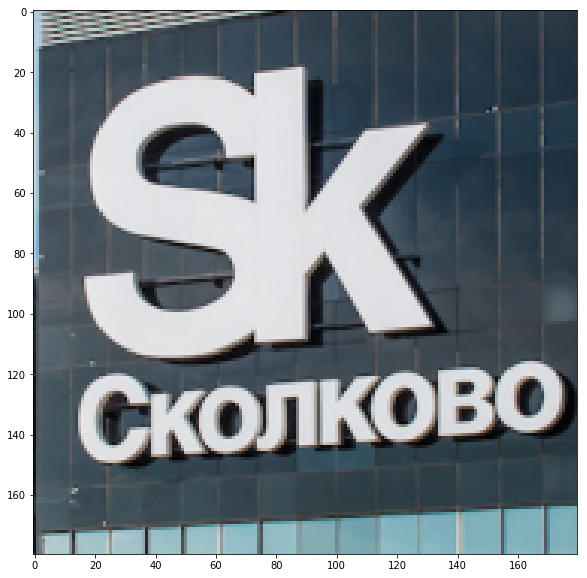

In [39]:
def create_gaussian_kernel(bound, size):
    t = np.linspace(-bound, bound, size)
    bump = np.exp(-0.1*t**2)
    kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
    kernel = kernel/kernel.sum()
    return kernel


kernel = create_gaussian_kernel(3, 15)

k = kernel.shape[0]


def padwithtens(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 0
    vector[-pad_width[1]:] = 0
    return vector

def resize_img(img, pad_size):
    y = np.zeros((img.shape[0]+pad_size[0]+pad_size[1], img.shape[1]+pad_size[0]+pad_size[1], 3))
    #should be square
    #print(y.shape)
    #print(np.lib.pad(img[:,:,0], pad_size, 'constant', constant_values=(0, 0, 0, 0)).shape)
    for i in range(3):
        y[:,:,i] = np.lib.pad(img[:,:,i], pad_size, padwithtens)
    return y.reshape(y.shape[0]**2, y.shape[2])

pad = (k//2,k//2+1)

img = plt.imread('skolkovo_tiny.png')
plt.figure(figsize = (10,10))
plt.imshow(img)

pad_img = resize_img(img, pad)

In [40]:
def create_matrix(kernel, image_size): # creates
    k = kernel.shape[0]
    tmp = np.zeros(((image_size+k)**2, image_size))
    tmp1 = np.zeros(((image_size+k)**2))
    for i in range(k):
        tmp1[i*(image_size+k):i*(image_size+k) + k] += kernel[i]
    tmp[:,0] += tmp1
    for i in range(1, image_size):
        tmp[i:,i] += tmp1[:-i]
    #print(tmp.shape)
    tmp = tmp.T
    k = kernel.shape[0]
    final = sparse.csr_matrix(tmp)
    tmp = sparse.csr_matrix(tmp)
    for i in range(1, image_size):
        sparse_zeros = sparse.csr_matrix(np.zeros((image_size, (image_size+k)*i)))
        sparse_tmp = sparse.csr_matrix(sparse.hstack((sparse_zeros, tmp[:,:-(image_size+k)*i])))
        final = sparse.vstack((final, sparse_tmp))
    return final

#kernel = create_gaussian_kernel(10, 30)

A = create_matrix(kernel, img.shape[0])

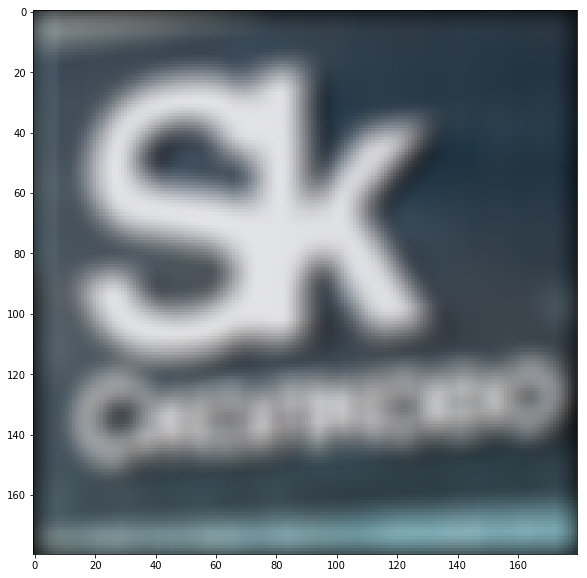

In [41]:
new_img = A@pad_img
new_size = int(np.sqrt(new_img.shape[0]))
blurred_img = new_img.reshape((new_size,new_size, 3))
plt.figure(figsize = (10,10))
plt.imshow(blurred_img)

In [42]:
sigma = 1e-3

blurred_with_noise = blurred_img + sigma*np.random.randn(blurred_img.shape[0],blurred_img.shape[1], 3)

# With $l_1$ regularization

Proximal function:

$\text{prox}_{\lambda f}(v) = \arg\min\limits_{x} (f(x) + 1/(2\lambda) \|x-v\|_2^2)$

$f(y) = 1/(2\sigma) \|z-Ay\|^2_2 + \tau \rho(y) = g(y) + h(y)$

$\rho(y) = \|y\|_1$

Proximal gradient method:

$y^{k+1} = \text{prox}_{\lambda^k g} (y^kf(y) - \lambda^k\nabla f(y^k))$

In case $g(y) = \|y\|_1$

$\text{prox}_{\lambda g}(u)_i = \begin{cases} u_i - \lambda, u_i \ge \lambda \\ 0, -\lambda \le u_i \le \lambda \\
u_i + \lambda, u_i \le -\lambda \end{cases}$

In [43]:
tau = 1e-3
y1 = resize_img(blurred_with_noise, pad)
#A = create_matrix(kernel, img.shape[0])
v = blurred_with_noise.reshape((blurred_with_noise.shape[0]**2, blurred_with_noise.shape[2]))[:,:3]

In [44]:
from sklearn.metrics import mean_squared_error as mse

def error(initial, deblurred):
    return mse(initial, deblurred) 

In [45]:
def f(y):
    return 1/(2*sigma)*np.linalg.norm(v - A@y, 2)**2

def func(y):

    return 1/(2*sigma)*np.linalg.norm(v - A@y, 2)**2 + tau*np.linalg.norm(y, 1)

def prox_1_norm(u, t):
    return np.clip(u - t, a_min = 0, a_max = None) + np.clip(u + t, a_min = None, a_max = 0)

def grad_f(y):
    return 1/sigma*A.T@(A@y - v)

def f_hat(y, z, l):
    return f(y) - np.multiply(y-z, grad_f(y)).sum() + 1/(2*l)*np.linalg.norm(y-z)**2


def projection(v):
    return np.clip(v, 0, 1)

def line_search(y, l, beta = 0.5):
    while True:
        z = projection(prox_1_norm(y - l*grad_f(y), l*tau))
        if f(z) <= f_hat(y, z, l):
            break
        else:
            l = beta*l
    return z, l

def prox_grad_descent(y0, l0, beta = 0.5, maxiter = 500, tol = 1e-2):
    l = l0
    y_0 = y0
    y = y0
    status = 0
    err = []
    loss = []
    #size = int(np.sqrt(y0.shape[0]))
    for i in tqdm(range(int(maxiter))):
        #if (i+1) % 100 == 0:
            #print('100 iterations exceeded')
        #y = prox_1_norm(y - l*grad_f(y), l*tau)
        #print(l)
        y, l = line_search(y_0, l, beta)
        err.append(error(y_0, pad_img))
        loss.append(func(y_0))
        if np.linalg.norm(y-y_0) < tol:
            status = 1
            break
        y_0 = y
    loss.append(func(y))
    err.append(error(y, pad_img))
    return y, status, err, loss

In [46]:
y, status, err_l1, loss_l1 = prox_grad_descent(y1, 5e-1, maxiter = 1000, tol = 1e-3)

100%|██████████| 1000/1000 [07:18<00:00,  2.28it/s]


In [47]:
size = int(np.sqrt(y.shape[0]))
t = y.reshape((size, size, y.shape[1]))

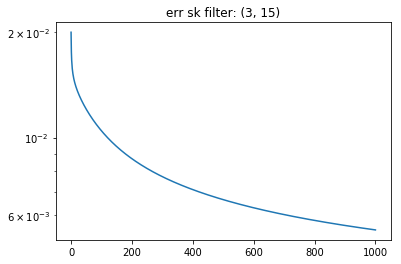

In [48]:
plt.semilogy(err_l1)
plt.title('err sk filter: (3, 15)')
#plt.savefig('err_skolkovo_l1_3_15.png')
plt.show()

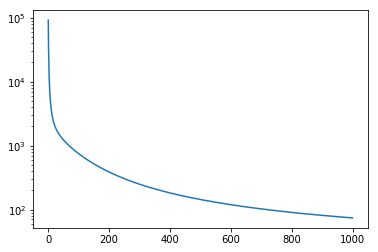

In [49]:
plt.semilogy(loss_l1)

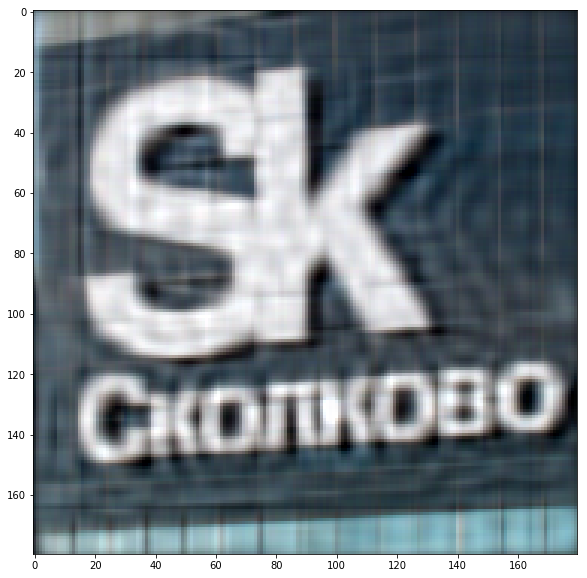

In [50]:
plt.figure(figsize = (10, 10))
plt.imshow(t[k//2:-(k//2+1), k//2:-(k//2+1)])
#plt.savefig('skolkovo_l1_3_15.eps')

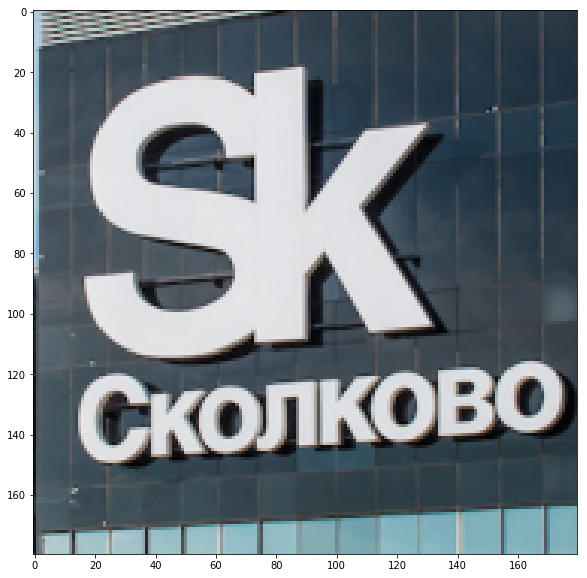

In [51]:
plt.figure(figsize = (10, 10))

plt.imshow(img)

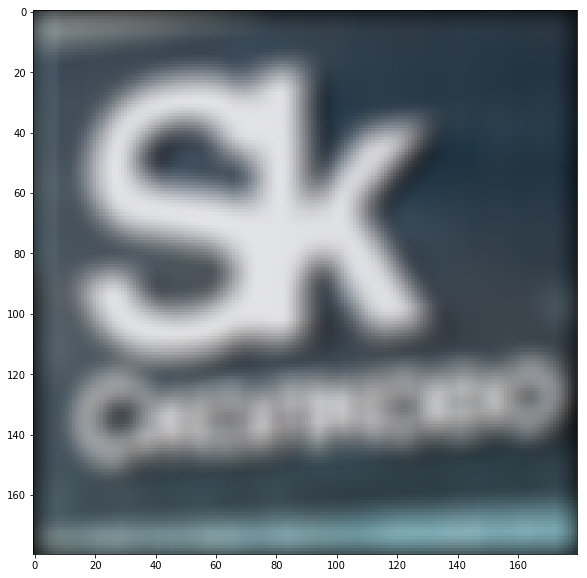

In [52]:
plt.figure(figsize = (10, 10))
plt.imshow(blurred_img)

In [53]:
imageio.imwrite('sk_restored_l1_3_15.png', t[k//2:-(k//2+1), k//2:-(k//2+1)])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [54]:
df = pd.read_csv('rmse.csv')
df1 = pd.read_csv('loss.csv')
df[2] = err_l1[:501]
df1[2] = loss_l1[:501]

### With $l_2$ regularization

In case $h(y) = \|y\|_2^2$

$\text{prox}_{\lambda g}(u) = \frac{1}{2\lambda+1} u$

In [55]:
tau = 1e-3
#A = create_matrix(kernel, img.shape[0])
v = blurred_with_noise.reshape((blurred_with_noise.shape[0]**2, blurred_with_noise.shape[2]))[:,:3]

In [56]:
y1 = resize_img(blurred_with_noise, pad)

In [57]:
def f(y):
    return 1/(2*sigma)*np.linalg.norm(v - A@y, 2)**2

def func(y):
    return 1/(2*sigma)*np.linalg.norm(v - A@y, 2)**2 + tau*np.linalg.norm(y,2)

def prox_2_norm(u, t):
    return 1/(2*t+1)*u

def grad_f(y):
    return 1/sigma*A.T@(A@y - v)

def f_hat(y, z, l):    
    return f(y) - np.multiply(y-z, grad_f(y)).sum() + 1/(2*l)*np.linalg.norm(y-z)**2

def projection(v):
    return np.clip(v, 0, 1)

def line_search(y, l, beta = 0.5):
    while True:
        z = projection(prox_2_norm(y - l*grad_f(y), l))
        if f(z) <= f_hat(y, z, l):
            break
        else:
            l = beta*l
    return z, l


def prox_grad_descent(y0, l0, beta = 0.5, maxiter = 1000, tol = 1e-2):
    l = l0*tau
    y_0 = y0
    y = y0
    status = 0
    err = []
    loss = []
    for i in tqdm(range(int(maxiter))):
        y, l = line_search(y_0, l, beta)
        err.append(error(y_0, pad_img))
        loss.append(func(y_0))
        if abs(func(y) - func(y_0)) < tol:
            status = 1
            break
        y_0 = y
    err.append(error(y, pad_img))
    loss.append(func(y))
    return y, status, err, loss

In [58]:
y, status, err_l2, loss_l2 = prox_grad_descent(y1, 0.5, maxiter = 1000, tol = 1e-3)

100%|██████████| 1000/1000 [08:26<00:00,  1.98it/s]


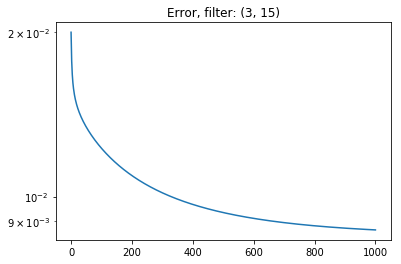

In [59]:
plt.semilogy(err_l2)
plt.title('Error, filter: (3, 15)')
#plt.savefig('err_skolkovo_l2_3_15.png')
plt.show()

(195, 195, 3)


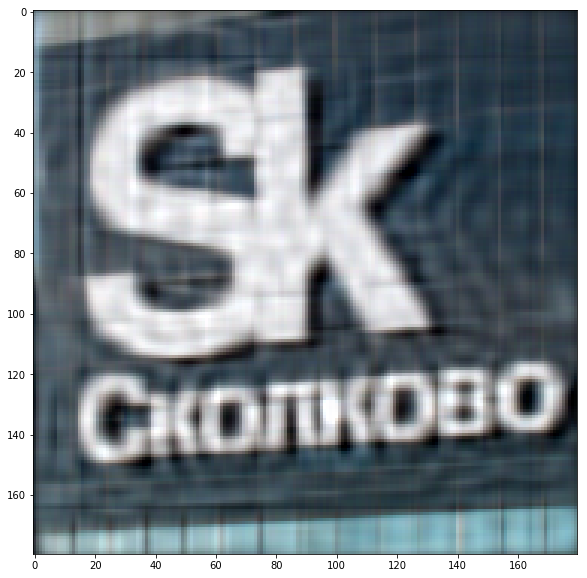

In [60]:
size = int(np.sqrt(y.shape[0]))
t2 = y.reshape((size, size, y.shape[1]))
print(t.shape)
t2 = np.append(t, np.ones((size,size,1)), axis = 2)
#t = np.clip(t, 0, 1)
plt.figure(figsize = (10, 10))
plt.imshow(t2[k//2:-(k//2+1), k//2:-(k//2+1)])
#plt.savefig('kremlin_l2_3_15.eps')

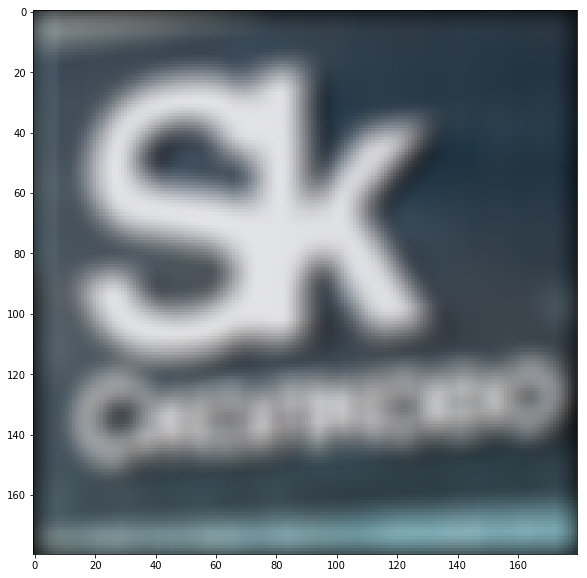

In [61]:
plt.figure(figsize = (10, 10))
plt.imshow(blurred_img)

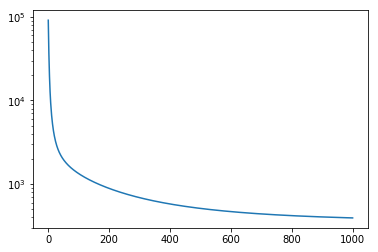

In [62]:
plt.semilogy(loss_l2)

In [63]:
#loss_l2 = func(y)
df[3] = err_l2[:501]
df1[3] = loss_l2[:501]

In [64]:
df1.to_csv('loss.csv')
df.to_csv('rmse.csv')

In [65]:
imageio.imwrite('sk_restored_l2_3_15.png', t2[k//2:-(k//2+1), k//2:-(k//2+1)])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [33]:
restored_l1 = plt.imread('sk_restored_l1_3_15.png')
restored_l2 = plt.imread('sk_restored_l2_3_15.png')

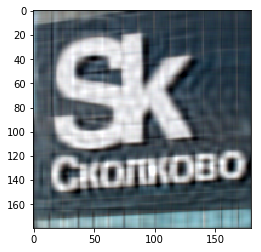

In [34]:
plt.imshow(restored_l1)

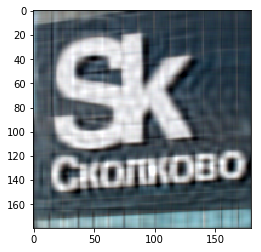

In [35]:
plt.imshow(restored_l2)

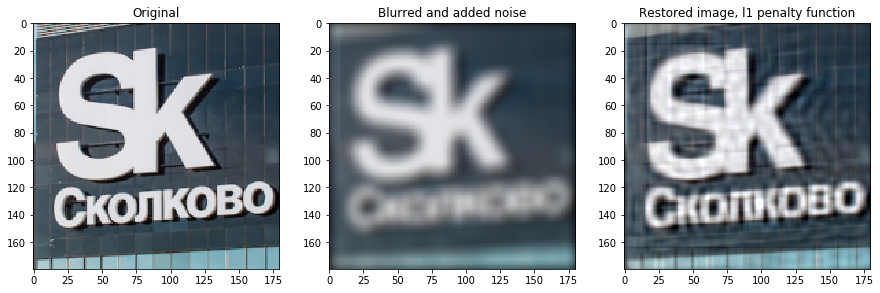

In [36]:
plt.figure(figsize = (15,5))
plt.tight_layout()
plt.subplot(131)
plt.title('Original')
plt.imshow(img)
plt.subplot(132)
plt.title('Blurred and added noise')
plt.imshow(blurred_with_noise)
plt.subplot(133)
plt.title('Restored image, l1 penalty function')
plt.imshow(restored_l1)
plt.savefig('l1_all_imgs_3_15.png')

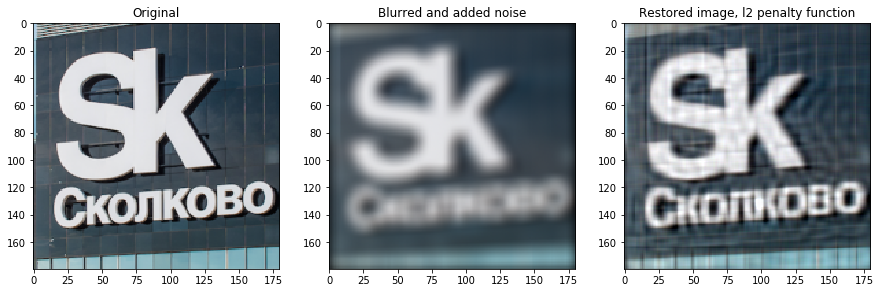

In [37]:
plt.figure(figsize = (15,5))
plt.tight_layout()
plt.subplot(131)
plt.title('Original')
plt.imshow(img)
plt.subplot(132)
plt.title('Blurred and added noise')
plt.imshow(blurred_with_noise)
plt.subplot(133)
plt.title('Restored image, l2 penalty function')
plt.imshow(restored_l2)
plt.savefig('l2_all_imgs_3_15.png')